In [1]:
import os
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
import random

import torch.nn.functional as F
from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

from utils.plot_image_grid import image_grid

In [2]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [3]:
TRAINING_NUM_VIEWS = 10
IMAGE_SIZE = 224
TRIANGLE_GRID_RESOLUTION = 10
INITIAL_TRIANGLE_GRID_COUNT = TRIANGLE_GRID_RESOLUTION ** 3

In [4]:
def create_initial_triangle_grid(grid_resolution, device=None):
    if device is None:
        device = torch.device("cpu")

    vertex_list = []
    index_list = []

    cell_size = 2.0 / grid_resolution

    for x in range(grid_resolution):
        for y in range(grid_resolution):
            for z in range(grid_resolution):
                # 当前单元的最小坐标（归一化到[-1,1]）
                x_min = (x / grid_resolution) * 2 - 1
                y_min = (y / grid_resolution) * 2 - 1
                z_min = (z / grid_resolution) * 2 - 1
                
                # 在单元内生成三个随机点构成三角形
                v0 = [
                    x_min + random.random() * cell_size * 0.01,
                    y_min + random.random() * cell_size * 0.01,
                    z_min + random.random() * cell_size * 0.01
                ]
                v1 = [
                    x_min + random.random() * cell_size * 0.01,
                    y_min + random.random() * cell_size * 0.01,
                    z_min + random.random() * cell_size * 0.01
                ]
                v2 = [
                    x_min + random.random() * cell_size * 0.01,
                    y_min + random.random() * cell_size * 0.01,
                    z_min + random.random() * cell_size * 0.01
                ]
                
                # 添加顶点和面
                base_idx = len(vertex_list)
                vertex_list.extend([v0, v1, v2])
                index_list.append([base_idx, base_idx+1, base_idx+2])


    verts = torch.tensor(vertex_list, dtype=torch.float32, device=device)
    faces = torch.tensor(index_list, dtype=torch.int64, device=device)

    return Meshes(verts=[verts], faces=[faces])

In [5]:
# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "bunny_mesh/bunny.obj")

# Load obj file
origin_mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = origin_mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
origin_mesh.offset_verts_(-center)
origin_mesh.scale_verts_((1.0 / float(scale)));

occluder_mesh = create_initial_triangle_grid(TRIANGLE_GRID_RESOLUTION, device=device)


e:\App\anaconda3\envs\torch3d\Lib\site-packages\pytorch3d-0.7.7-py3.11-win-amd64.egg\pytorch3d\io\obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [6]:
# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, TRAINING_NUM_VIEWS)
azim = torch.linspace(-180, 180, TRAINING_NUM_VIEWS)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...]) 


In [7]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=IMAGE_SIZE, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

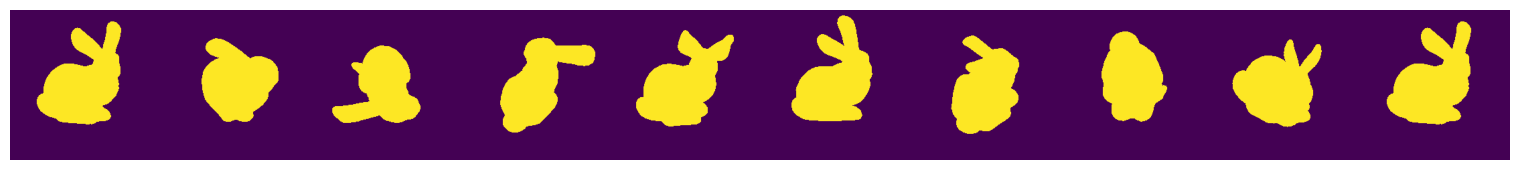

torch.Size([10, 1, 224, 224])


In [8]:
origin_meshes = origin_mesh.extend(TRAINING_NUM_VIEWS)

# Render silhouette images.  The 3rd channel of the rendering output is the alpha/silhouette channel
origin_images = renderer_silhouette(origin_meshes, cameras=cameras, lights=lights)
origin_images[origin_images > 0] = 1.0

# target_silhouette = [origin_images[i, ..., 3] for i in range(TRAINING_NUM_VIEWS)]
# Visualize silhouette images
image_grid(origin_images.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // 10 + 1, cols=10, rgb=False)
plt.show()


gt_silhouettes = (origin_images[..., 3] > 0).float().unsqueeze(1)  # (B, 1, H, W)
print(gt_silhouettes.shape)

# origin_images = origin_images[..., [0, 1, 3]]
# origin_images = origin_images.permute(0, 3, 1, 2)


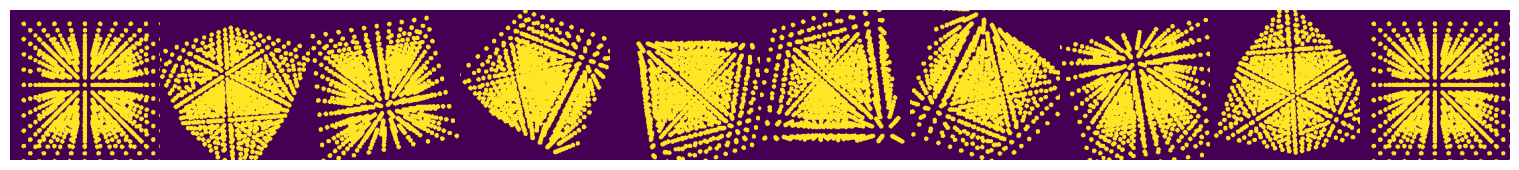

In [9]:
occluder_meshes = occluder_mesh.extend(TRAINING_NUM_VIEWS)

# Render silhouette images.  The 3rd channel of the rendering output is the alpha/silhouette channel
occluder_images = renderer_silhouette(occluder_meshes, cameras=cameras, lights=lights)
occluder_images[occluder_images > 0] = 1.0

target_silhouette = [occluder_images[i, ..., 3] for i in range(TRAINING_NUM_VIEWS)]

# Visualize silhouette images
image_grid(occluder_images.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // 10 + 1, cols=10, rgb=False)
plt.show()

In [10]:
class TrLoss(nn.Module):
    def __init__(self, alpha=1600.0, beta=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def calc_area_loss(self, verts):
        # 顶点形状: (num_triangles*3, 3)
        triangles = verts.view(-1, 3, 3)  # (N, 3, 3)
        v1 = triangles[:, 1] - triangles[:, 0]
        v2 = triangles[:, 2] - triangles[:, 0]
        cross = torch.cross(v1, v2, dim=1)
        area = 0.5 * torch.norm(cross, dim=1)
        return torch.log1p(area).mean()

    def forward(self, pred_silhouettes, gt_silhouettes, verts):
        # 过度遮挡损失
        # To prevent the output from over occlusion, we design an over occlusion loss $loss_o$
        loss_o = torch.mean((1 - gt_silhouettes) * pred_silhouettes) 

        # 形状匹配损失
        #  On the other hand, to encourage the network output to cover as many occluded pixels as possible, we define the occluded loss $loss_u$
        loss_u = -torch.mean(gt_silhouettes * pred_silhouettes)

        # 面积正则化
        #Finally, we need to penalize the network for using unnecessary triangles, we accomplish this by calculating the means of log area of all triangles
        loss_r = self.calc_area_loss(verts)
        
        return loss_u + self.alpha * loss_o + self.beta * loss_r

In [11]:
class ConvNeXtRegression(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        base_model = models.convnext_small(pretrained=True)  # 加载预训练权重
        
        # 调整第一层卷积为单通道输入
        original_conv = base_model.features[0][0]
        new_conv = nn.Conv2d(1, original_conv.out_channels, 
                            kernel_size=original_conv.kernel_size,
                            stride=original_conv.stride,
                            padding=original_conv.padding)
        
        # 初始化新卷积层权重：取RGB三通道均值
        with torch.no_grad():
            new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)
        
        base_model.features[0][0] = new_conv
        self.feature_extractor = base_model.features
        
        # 多视角特征聚合
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 回归头调整
        self.regressor = nn.Sequential(
            nn.Linear(768, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Linear(512, num_outputs)
        )

    def forward(self, x):
        # x形状: (num_views, 3, H, W)
        num_views = x.size(0)
        
        # 提取各视角特征
        features = [self.feature_extractor(x[i].unsqueeze(0)) for i in range(num_views)]
        features = torch.cat(features, dim=0)  # (num_views, 768, 7, 7)
        
        # 全局平均池化并聚合
        pooled = self.avgpool(features).view(num_views, -1)  # (num_views, 768)
        global_feature = pooled.mean(dim=0, keepdim=True)     # (1, 768)
        
        # 回归偏移量
        return self.regressor(global_feature)  # (1, num_outputs)

In [12]:
def create_offset_mesh(mesh, offset):
    vertex_list = mesh.verts_list()[0] + offset
    index_list = mesh.faces_list()[0]
    verts = torch.tensor(vertex_list, dtype=torch.float32, device=device)
    faces = torch.tensor(index_list, dtype=torch.int64, device=device)

    return Meshes(verts=[verts], faces=[faces])

In [13]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 1000

# The optimizer
model = ConvNeXtRegression(INITIAL_TRIANGLE_GRID_COUNT * 9).to(device)  # 每个三角形3顶点×3坐标
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = TrLoss(alpha=1600, beta=0.6)
# loss = TrLoss()

e:\App\anaconda3\envs\torch3d\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\App\anaconda3\envs\torch3d\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
loop = tqdm(range(Niter))

for i in loop:
    optimizer.zero_grad()
    
    elev = torch.rand(TRAINING_NUM_VIEWS) * 360
    azim = torch.rand(TRAINING_NUM_VIEWS) * 360 - 180
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
    R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    origin_images = renderer_silhouette(origin_meshes, cameras=cameras, lights=lights)
    gt_silhouettes = (origin_images[..., 3] > 0).float().unsqueeze(1)  # (B, 1, H, W)


    # 模型预测 
    offsets = model(gt_silhouettes)  # 输入通道适配
    
    # 应用偏移量
    new_verts = occluder_mesh.verts_padded() + offsets.view(1, -1, 3)
    proxy_mesh = Meshes(verts=new_verts, faces=occluder_mesh.faces_padded())
    
    # 渲染代理
    pred_silhouettes = renderer_silhouette(proxy_mesh.extend(TRAINING_NUM_VIEWS), cameras=cameras)[..., 3].unsqueeze(1)  # (B, 1, H, W)

    # 计算损失
    loss = criterion(pred_silhouettes, gt_silhouettes, new_verts)
    
    # 反向传播
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {i}: Loss {loss.item():.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss 1235.2828
Epoch 1: Loss 1252.1755
Epoch 2: Loss 1221.3976
Epoch 3: Loss 1130.7573
Epoch 4: Loss 1061.0359
Epoch 5: Loss 1005.9819
Epoch 6: Loss 974.9823
Epoch 7: Loss 833.4025
Epoch 8: Loss 759.4445
Epoch 9: Loss 703.3828
Epoch 10: Loss 602.2080
Epoch 11: Loss 544.8885
Epoch 12: Loss 484.9186
Epoch 13: Loss 404.2368
Epoch 14: Loss 410.7954
Epoch 15: Loss 358.2442
Epoch 16: Loss 290.4384
Epoch 17: Loss 228.5902
Epoch 18: Loss 238.5845
Epoch 19: Loss 208.3320
Epoch 20: Loss 156.6453
Epoch 21: Loss 154.9097
Epoch 22: Loss 132.6560
Epoch 23: Loss 129.8410
Epoch 24: Loss 143.5369
Epoch 25: Loss 108.7121
Epoch 26: Loss 102.8505
Epoch 27: Loss 77.6639
Epoch 28: Loss 79.6452
Epoch 29: Loss 69.1153
Epoch 30: Loss 76.4133
Epoch 31: Loss 61.1313
Epoch 32: Loss 45.3219
Epoch 33: Loss 41.2121
Epoch 34: Loss 53.4615
Epoch 35: Loss 47.0839
Epoch 36: Loss 35.8786
Epoch 37: Loss 36.3753
Epoch 38: Loss 39.8302
Epoch 39: Loss 33.2124
Epoch 40: Loss 29.8716
Epoch 41: Loss 30.8456
Epoch 42: L

In [ ]:
def delete_small_triangles(mesh, threshold):
    """
    直接删除网格中面积小于阈值的三角形，返回新网格
    
    Args:
        mesh (Meshes): PyTorch3D的Meshes对象（仅单个网格）
        threshold (float): 面积阈值
    
    Returns:
        Meshes: 处理后的新网格，包含所有面积≥阈值的三角形
    """
    assert mesh._N == 1, "仅支持单个网格处理"
    
    # 获取顶点和面数据
    verts = mesh.verts_packed()  # [V, 3]
    faces = mesh.faces_packed()  # [F, 3]
    
    tri_verts = verts[faces]
    v0, v1, v2 = tri_verts[:, 0], tri_verts[:, 1], tri_verts[:, 2]

    cross = torch.cross(v1 - v0, v2 - v0, dim=1)
    area = torch.norm(cross, dim=1) / 2.0  # [F]
    
    delete_mask = area < threshold
    
    valid_faces = faces[~delete_mask]

    used_verts_idx = torch.unique(valid_faces.flatten())

    verts_map = torch.full((verts.shape[0],), -1, dtype=torch.long, device=verts.device)
    verts_map[used_verts_idx] = torch.arange(len(used_verts_idx), device=verts.device)

    new_faces = verts_map[valid_faces]
    new_verts = verts[used_verts_idx]
    

    return Meshes(verts=[new_verts], faces=[new_faces])

Before delete small triangle, triangle count =  1000


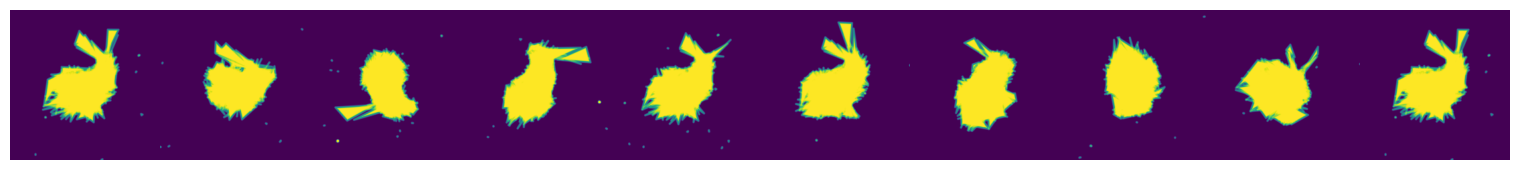

tensor([[-0.1659, -0.4044, -0.6168,  ..., -0.8797, -0.7198, -0.6870]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [16]:
offsets = model(gt_silhouettes)
new_verts = occluder_mesh.verts_padded() + offsets.view(1, -1, 3)
proxy_mesh = Meshes(verts=new_verts, faces=occluder_mesh.faces_padded())
print("Before delete small triangle, triangle count = ", proxy_mesh.verts_list()[0].shape[0] // 3)

elev = torch.linspace(0, 360, TRAINING_NUM_VIEWS)
azim = torch.linspace(-180, 180, TRAINING_NUM_VIEWS)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)

pred_silhouettes = renderer_silhouette(proxy_mesh.extend(TRAINING_NUM_VIEWS), cameras=FoVPerspectiveCameras(device=device, R=R, T=T))
pred_silhouettes = pred_silhouettes.detach()
image_grid(pred_silhouettes.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // 10 + 1, cols=10, rgb=False)
plt.show()
print(offsets)

After delete small triangle, triangle count =  69


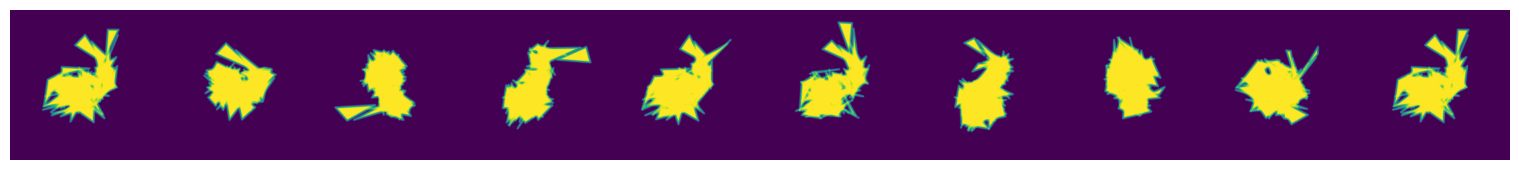

tensor([[-0.1659, -0.4044, -0.6168,  ..., -0.8797, -0.7198, -0.6870]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [17]:
proxy_mesh = delete_small_triangles(proxy_mesh, 0.06)
print("After delete small triangle, triangle count = ", proxy_mesh.verts_list()[0].shape[0] // 3)

pred_silhouettes = renderer_silhouette(proxy_mesh.extend(TRAINING_NUM_VIEWS), cameras=FoVPerspectiveCameras(device=device, R=R, T=T))
pred_silhouettes = pred_silhouettes.detach()
image_grid(pred_silhouettes.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // 10 + 1, cols=10, rgb=False)
plt.show()
print(offsets)